In [1]:
# try to install tensorflow 2.0 beta if not install
tf  = ! pip list | grep tensorflow-gpu
if len(tf) == 0 or tf[0].split()[-1] != '2.0.0b0':
  ! pip install tensorflow-gpu==2.0.0-beta0
else:
  print('You already installed tensorflow 2.0 beta')

     |████████████████████████████████| 348.9MB 77kB/s 
     |████████████████████████████████| 3.1MB 45.8MB/s 
     |████████████████████████████████| 501kB 45.8MB/s 


# Prefix
In this notebook we are going to be using a pretrained model to classify horses and humans images. The model we will be using is the InceptionV3 model, it is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. (For more information on the architecture of the model please read this paper: [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567))

# Step - 1: Loading the Pretrain Model

In [0]:
import os, zipfile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Download the save weights

In [3]:
# Download the inception v3 weights
if not os.path.exists("/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"):
  !wget --no-check-certificate \
      https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
      -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
else:
  print('Weights already downloaded')

--2019-06-13 23:17:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  64.8MB/s    in 1.3s    

2019-06-13 23:17:45 (64.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



After downloading the weights we are going to load the InceptionV3 model from keras with the saved weights, and then freezing the weights of the model.

In [4]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Pointer to the loaded weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Setting the input_shape and not import the weights 
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# Load the weights from file to model
pre_trained_model.load_weights(local_weights_file)

# Freeze all the layers in the pre-trained model
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add new output layers
Taking the outputs of a selected layer and then adding it to our model.

In [5]:
# Pick the last layer for the new output
last_layer = pre_trained_model.get_layer('mixed7')
# Check the output shape of layer picked
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Building the new output of the model
x = Flatten()(last_output)
x = Dense(1024, activation='relu')(x)
# Adding Dropout layer to the model for limiting overfitting
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Step - 2 : Training the model

In [0]:
# Define a Callback to stop training once training accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc')>0.99):
      print("\nReached 99.9% training accuracy, training STOP!")
      self.model.stop_training = True

### Download the datasets
We could use the python wget library for downloading the zip files instead of using the ! wget command.

In [12]:
# using the wget library to download the datasets
! pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
# Helper function for extracting zip files
def extract_zip(fpath, dpath):
  with zipfile.ZipFile(fpath, 'r') as zip_ref:
    zip_ref.extractall(dpath)

# Helper function for downloading and extracting the zip file
def download_dataset(link, dpath, base='/tmp/'):
  import wget
  # get the zip file name from the last part of the link
  zip_name = link.split('/')[-1]
  # download the zip if zip file not downloaded
  if not os.path.exists(base+zip_name):
    # Get the Horse or Human dataset
    wget.download(url=link, out=base+zip_name)
    downloaded = True
  else:
    downloaded=True

  if not os.path.exists(base+dpath):
    # extracting the zipfile
    extract_zip(base+zip_name, base+dpath)
    extracted = True
  else:
    extracted = True
  
  if downloaded and extracted:
    print(dpath, 'set is ready to go:')
    dir_name = os.listdir(base+dpath)
    for dn in dir_name:
      num_files = os.listdir(base+dpath+'/'+dn)
      print('With {} images in the {} directory'.format(len(num_files), dn))
  else:
    print('Something went wrong!')

In [55]:
training_link = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip"
validation_link = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip"

download_dataset(training_link, 'training')
download_dataset(validation_link, 'validation')

training set is ready to go:
With 500 images in the horses directory
With 527 images in the humans directory
validation set is ready to go:
With 128 images in the horses directory
With 128 images in the humans directory


### Augmenting the training dataset

In [14]:
# Define directories for training and validation
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

# Note validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training and validation images in batches of 20 using the data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    class_mode='binary',
                                                    batch_size=20)

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150,150),
                                                        class_mode='binary',
                                                        batch_size=20)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Start the training
We created the callbacks early to have the model stop training when the training accuracy reaches 99.9%.

In [15]:
# create callback
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=100,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

Epoch 1/100


W0613 23:31:52.148613 140520226412416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


52/52 [==============================] - 23s 439ms/step - loss: 0.5876 - acc: 0.8578 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 2/100
52/52 [==============================] - 11s 212ms/step - loss: 0.2571 - acc: 0.9387 - val_loss: 0.0069 - val_acc: 0.9961
Epoch 3/100
52/52 [==============================] - 12s 229ms/step - loss: 0.2222 - acc: 0.9299 - val_loss: 0.0179 - val_acc: 0.9922
Epoch 4/100
52/52 [==============================] - 12s 231ms/step - loss: 0.1080 - acc: 0.9611 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/100
52/52 [==============================] - 12s 231ms/step - loss: 0.1203 - acc: 0.9630 - val_loss: 0.0623 - val_acc: 0.9844
Epoch 6/100
52/52 [==============================] - 12s 230ms/step - loss: 0.1165 - acc: 0.9698 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 7/100
52/52 [==============================] - 12s 232ms/step - loss: 0.1077 - acc: 0.9718 - val_loss: 0.0030 - val_acc: 0.9961
Epoch 8/100
52/52 [==============================] - 12s 233ms/step - loss

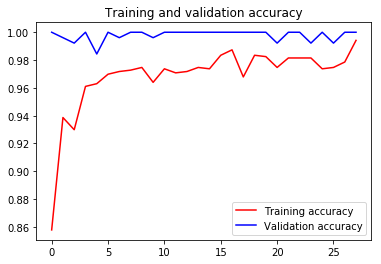

<Figure size 432x288 with 0 Axes>

In [16]:
# Plotting the history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Step - 3 : Test the New Model
We will be randomly choosing 10 images in the validation directory, and have our model predict if is a human or a horse.

In [0]:
# combining the images path from horses and humans directory into a python list
horses_list = ['/tmp/validation/horses/'+p for p in os.listdir('/tmp/validation/horses')]
humans_list = ['/tmp/validation/humans/'+p for p in os.listdir('/tmp/validation/humans')]

images_list = horses_list + humans_list

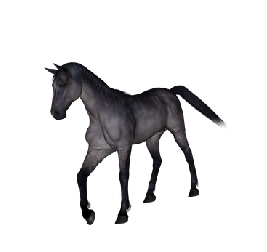

The model predict the above imageto be a horse and the model is correct :)!


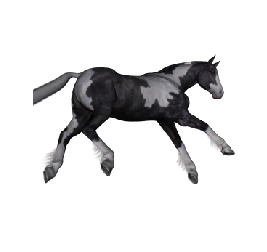

The model predict the above imageto be a horse and the model is correct :)!


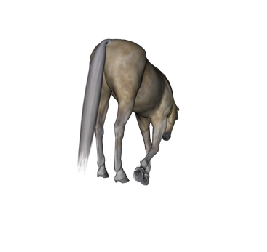

The model predict the above imageto be a horse and the model is correct :)!


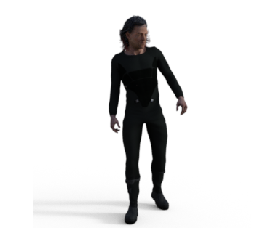

The model predict the above imageto be a human and the model is correct :)!


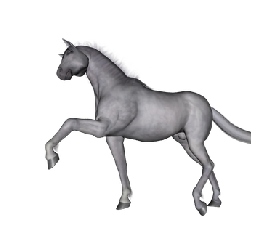

The model predict the above imageto be a horse and the model is correct :)!


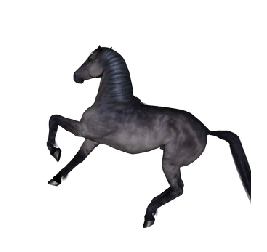

The model predict the above imageto be a horse and the model is correct :)!


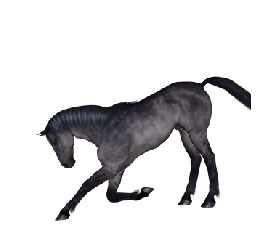

The model predict the above imageto be a horse and the model is correct :)!


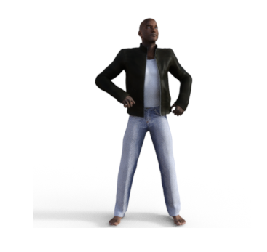

The model predict the above imageto be a human and the model is correct :)!


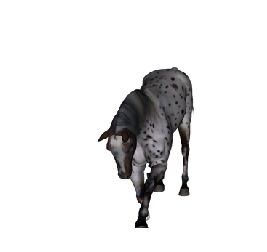

The model predict the above imageto be a horse and the model is correct :)!


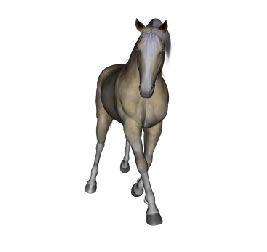

The model predict the above imageto be a horse and the model is correct :)!


In [53]:
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

# randomly selecting n images
num_tests = 10  # changes this to pick more or less images
random_image = np.random.choice(images_list, size=num_tests, replace=False)
# starting the plot fig
fig = plt.gcf()
fig.set_size_inches(4, 4)
for rand in random_image:
  # using pillow to load the image
  im = Image.open(rand)
  im = im.convert('RGB')  # convert to RGB so it will have 3 channels
  resize = im.resize((150, 150))  # resizing it to match the input shape
  # convert the image to a numpy array and than normalize its color scale with 1./255.
  data = np.array(resize)/255.
  # using our newly trained model for prediction
  p = model.predict(np.expand_dims(data, axis=0))
  # if p less than .5 is horse else is human
  predict = 'horse' if p < .5 else 'human'
  # plotting the image with matplot lib
  img = mpimg.imread(rand)
  plt.imshow(img, label='horse')
  plt.axis('off')
  plt.show()
  # checking if the prediction is correct or not
  label = rand.split('/')[-2][:-1]
  is_correct = 'correct :)!' if predict == label else 'incorrect :(!'
  print('The model predict the above image'
        'to be a {} and the model is {}'.format(
        predict, is_correct))